In [111]:
import torch
import math
from matplotlib import pyplot as plt
from torch.autograd import grad

N = 400               # numero total de amostras do dataset
NOISE = 20.           # intensidade do ruido de coleta no dataset
SPLIT_RATIO = 0.5     # porcentagem de dados usados no dataset de treino
BATCH_SIZE = 10       # tamanho do batch usado durante o treinamento
LEARNING_RATE = 0.03  # taxa de aprendizado

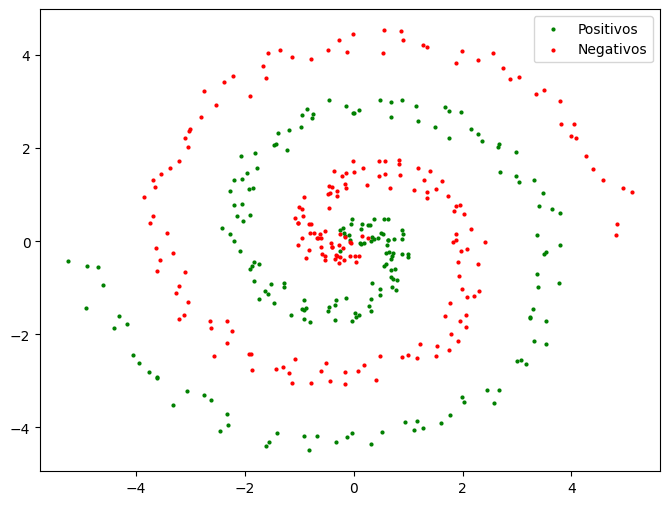

In [112]:
def genSpiral(delta_t, label):
    r = 5*torch.linspace(0., 1., N//2+1)[:N//2]
    t = 0.7*r*math.pi + delta_t
    x0 = r*torch.sin(t)
    x1 = r*torch.cos(t)
    y = label*torch.ones_like(x0)
    x = torch.stack((x0, x1), -1)
    sampled_noise = (NOISE/70.)*(2*torch.rand(N//2, 2) - 1.)
    x += sampled_noise
    return x, y

class SpiralDataset:
    def __init__(self):
        xp, yp = genSpiral(0, 1) # positive samples
        xn, yn = genSpiral(math.pi, -1) # negative samples
        self.X = torch.cat((xp, xn))
        self.Y = torch.cat((yp, yn))


df_Spiral = SpiralDataset()


#df.X ->conjuntos de pontos (x,y) de um sistema de coordenadas cartesianas
#df.Y ->rótulos (positivo/negativo) de cada conjunto de pontos





positivos = df_Spiral.X[df_Spiral.Y==1] #conjunto de 200 pontos com rótulo positivo
negativos = df_Spiral.X[df_Spiral.Y==-1] #conjunto de 200 pontos com rótulo negativo
plt.figure(figsize=(8, 6))
plt.scatter(positivos[:,0], positivos[:,1], color = 'green', label='Positivos', s = 4)
plt.scatter(negativos[:,0], negativos[:,1], color = 'red', label='Negativos', s = 4)
plt.legend()
plt.show()



# TODO: plotar dataset gerado

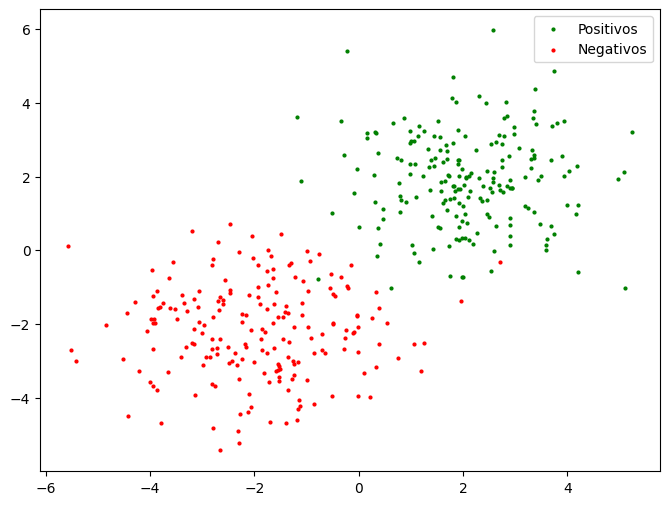

In [113]:
def genGauss(cx0, cx1, label):
    x = 0.7*torch.randn(N//2, 2)
    x = torch.tensor([cx0, cx1]) + x + x*(NOISE/25.)
    y = label*torch.ones(N//2)
    return x, y

class GaussDataset:
    def __init__(self):
        xp, yp = genGauss(2, 2, 1) # positive samples
        xn, yn = genGauss(-2, -2, -1) # negative samples
        self.X = torch.cat((xp, xn))
        self.Y = torch.cat((yp, yn))

df_Gauss = GaussDataset()


positives = df_Gauss.X[df_Gauss.Y==1]
negatives = df_Gauss.X[df_Gauss.Y==-1]
plt.figure(figsize=(8, 6))
plt.scatter(positives[:,0], positives[:,1], color = 'green', label='Positivos', s=4)
plt.scatter(negatives[:,0], negatives[:,1], color = 'red', label='Negativos', s=4)
plt.legend()
plt.show()

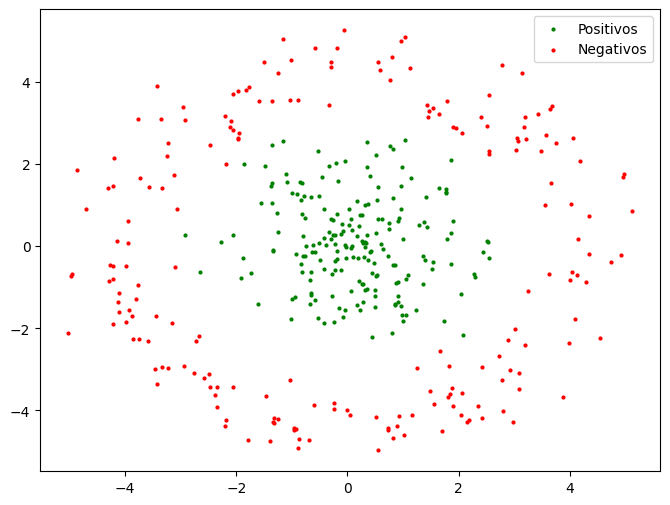

In [114]:
def genCircle(r_min, r_max, label):
    r = (r_max - r_min)*torch.rand(N//2) + r_min
    angle = 2*math.pi*torch.rand(N//2)
    x0 = r*torch.sin(angle)
    x1 = r*torch.cos(angle)
    x = torch.stack((x0, x1), -1)
    sampled_noise = (NOISE/35.)*(2*torch.rand(N//2, 2) - 1.)
    x += sampled_noise
    y = label*torch.ones_like(x0)
    return x, y

class CircleDataset:
    def __init__(self):
        xp, yp = genCircle(0, 2.5, 1) # positive samples
        xn, yn = genCircle(3.5, 5, -1) # negative samples
        self.X = torch.cat((xp, xn))
        self.Y = torch.cat((yp, yn))


df_Circle = CircleDataset()

positives = df_Circle.X[df_Circle.Y==1]
negatives = df_Circle.X[df_Circle.Y==-1]
plt.figure(figsize=(8, 6))
plt.scatter(positives[:,0], positives[:,1], color = 'green', label='Positivos', s=4)
plt.scatter(negatives[:,0], negatives[:,1], color = 'red', label='Negativos', s=4)
plt.legend()
plt.show()

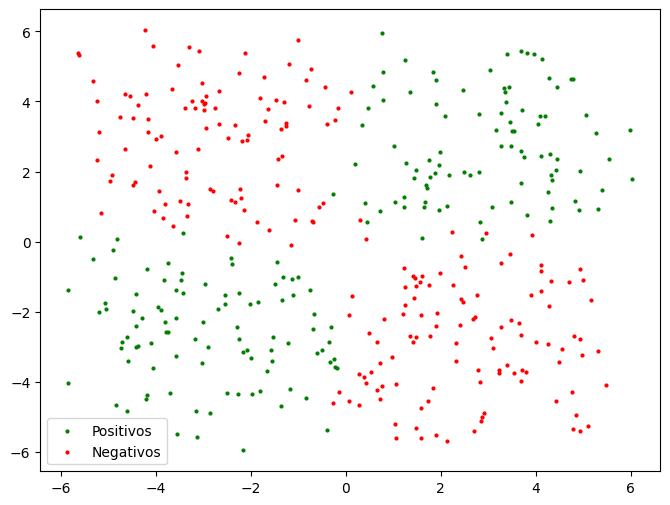

In [115]:
def genXOR():
    x = 10.*torch.rand(N, 2) - 5.
    y = torch.sign(x[:,0]*x[:,1])
    padding = 0.3
    x += torch.sign(x)*padding
    sampled_noise = (NOISE/25.)*(2*torch.rand(N, 2) - 1.)
    x += sampled_noise
    return x, y

class XORDataset:
    def __init__(self):
        self.X, self.Y = genXOR()

df_XOR = XORDataset()

positives = df_XOR.X[df_XOR.Y==1]
negatives = df_XOR.X[df_XOR.Y==-1]
plt.figure(figsize=(8, 6))
plt.scatter(positives[:,0], positives[:,1], color = 'green', label='Positivos', s=4)
plt.scatter(negatives[:,0], negatives[:,1], color = 'red', label='Negativos', s=4)
plt.legend()
plt.show()
# TODO: plotar dataset gerado

In [116]:
# TODO

import torch

def train_test_split(df_x, df_y):



  index = torch.randperm(len(df_x))
  index_split_train = index[:int(len(df_x)*SPLIT_RATIO)]
  index_split_test = index[int(len(df_y)*SPLIT_RATIO):]


  X_train = df_x[index_split_train]
  Y_train = df_y[index_split_train]

  X_test = df_x[index_split_test]
  Y_test = df_y[index_split_test]

  return X_train, Y_train, X_test, Y_test


In [117]:
df_Gauss.Y = torch.where(df_Gauss.Y == -1, torch.tensor(0), df_Gauss.Y)   #Estou transofrmando os targets -1 em 0
df_XOR.Y = torch.where(df_XOR.Y == -1, torch.tensor(0), df_XOR.Y)
df_Spiral.Y = torch.where(df_Spiral.Y == -1, torch.tensor(0), df_Spiral.Y)
df_Circle.Y = torch.where(df_Circle.Y == -1, torch.tensor(0), df_Circle.Y)

# **M**ulti**L**ayer **P**erceptron (**MLP**)

Incluindo diversas camadas de ativação

In [291]:
def func_ativ(func, x):
    if func == 'sigmoid':
        return 1 / (1 + torch.exp(-x))   #sigmoid

    if func == 'relu':
        return torch.relu(x)    #relu

    if func == 'tanh':
        return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))   #tangente hiperbólica

In [119]:
class Perceptron:
    def __init__(self, qtd_entradas, ativacao='sigmoid'):
        self.qtd_features = qtd_entradas
        self.ws = torch.rand(qtd_entradas, requires_grad=True)  #vamos inicializar n pesoscom, onde n é a quantidade de entradas do neurônio, com valores entre 0 e 1
        self.bias = torch.rand(1, requires_grad=True)   #Inicializando um bias (viés)
        self.ativacao = ativacao

    def inference(self, inp):
        return func_ativ(self.ativacao, torch.matmul(self.ws, torch.tensor(inp,dtype=torch.float)) + self.bias)  #aplica a função de ativação escolhida para  o somatorio das entradas * seus respectivos pesos, adicionado de um bias



In [120]:
class Camada:
        def __init__(self, n_neuronios, n_pesos, ativ='sigmoid'):    #A classe camada cria uma lista, onde armazenamos a quantidade de neurônios existentes naquela camada
            neuronios = []
            for i in range(n_neuronios):
                neuronios.append(Perceptron(n_pesos, ativacao=ativ))

            self.neuronios = neuronios

        def inference(self, inp):   #retorna um tensor(lista) das inferencias de cada neuronio da camada, na posição 0, está a inferência do neurônio 1, e assim por diante.
            return torch.tensor([n.inference(inp) for n in self.neuronios])

In [121]:
class Model:
    def __init__(self, n_features, n_camadas, neuronios_camada=None, ativacao='sigmoid'):

        if neuronios_camada == None:
            neuronios_camada = [2] * (n_camadas - 1) + [1]

        self.neuronios_por_camada = neuronios_camada
        self.n_camadas = n_camadas
        self.camadas_ocultas = n_camadas - 2
        self.ativacao = ativacao

        if n_camadas > 1:
          self.camadas = (
                  [Camada(self.neuronios_por_camada[0], n_features, ativ=self.ativacao)] +
                  [Camada(self.neuronios_por_camada[i], self.neuronios_por_camada[i -1],ativ=self.ativacao) for i in range(1, self.camadas_ocultas +1)] +   #Aqui criamos as camadas, onde a primeira camada lida com o input
                  [Camada(self.neuronios_por_camada[-1], self.neuronios_por_camada[-2],ativ=self.ativacao)]  # as camadas em diante lidam com os outputs da camada anterior, até a última camada
          )
        else:
          self.camadas = [Camada(self.neuronios_por_camada[0], n_features,ativ=self.ativacao)]

    def zerograd(self):   #Fução para zerar os gradientes de todos os pesos e bias de todos os neurônios envolvidos no modelo, útil para o backpropagation
        for l in self.camadas:
            for n in l.neuronios:
                if n.ws.grad is not None:
                    n.ws.grad.zero_()
                if n.bias.grad is not None:
                    n.bias.grad.zero_()

    def inference(self, inp):
      inp = torch.tensor(inp, dtype=torch.float).T
      prop_value = inp

      for l in self.camadas:
        prop_value = torch.stack( [ n.inference(prop_value) for n in l.neuronios])

      return prop_value

    def evaluate(self, x, target, threshold=0.5):  #Função para avaliar acurácio, onde temos um limiar de 0.5. Ou seja, todos os valores acima disso virarão positivo (1), e abaixo negativo (0)
      erro = 0
      acerto = 0

      for i, xi in enumerate(x):
          y_hat = self.inference(xi)

          y_hat_class = 1 if y_hat >= threshold else 0

          if y_hat_class != target[i]:
              erro += 1
          else:
              acerto += 1

      accuracy = acerto / (acerto + erro) if (acerto + erro) > 0 else 0
      print(f'Erros: {erro}')
      print(f'Acertos: {acerto}')
      print(f'Acurácia do mlp: {accuracy:.4f}')

Possibilitando a esolha de diferentes métodos para o cáclulo de loss

In [146]:
def calcula_loss(y, y_hat, metodo='abs'):  #Assim como a escolha da função de ativação, também é possível escolher a função de erro
  if metodo == 'binary_cross_entropy':
    return - (y * torch.log(y_hat) + (1 - y) * torch.log(1 - y_hat))

  if metodo == 'mse':
    return (y-y_hat)**2

  if metodo == 'abs':
    return abs(y-y_hat)

In [459]:
def train_loop(model, x, target, epocas, learning_rate, batch_size=5, metodo_loss='abs', ativacao='sigmoid'):
    X_train, Y_train, X_test, Y_test = train_test_split(x, target) #a divisão entre treino e teste será feita na propria função, para que não fiquem muitos parâmetros

    x = X_train
    target = Y_train
    model.ativacao = ativacao


    # Listas para armazenar os valores de perda
    test_losses = []
    train_losses = []

    for epc in range(epocas):  #Para cada época iremos percorrer todos os dados, calcular a inferência,e a partir do erro (por lotes (batch_size)) com o backpropagation atualizar os pesos e bias .
        losses = []

        with torch.no_grad():
            test_batch_y_hat = [model.inference(xi) for xi in X_test]
            test_batch_loss = [calcula_loss(ti, yi, metodo_loss) for ti, yi in zip(Y_test, test_batch_y_hat)]
            test_loss_media = (sum(test_batch_loss) / len(test_batch_loss)).item()
            test_losses.append(test_loss_media)


        for batch_start in range(0, len(x), batch_size):
            batch_end = min(batch_start + batch_size, len(x))
            batch_x = x[batch_start:batch_end]
            batch_target = target[batch_start:batch_end]

            model.zerograd()
            batch_y_hat = [model.inference(xi) for xi in batch_x]
            batch_loss = [calcula_loss(ti, yi, metodo_loss) for ti, yi in zip(batch_target, batch_y_hat)]


            losses.extend([loss.item() for loss in batch_loss])

            batch_loss = sum(batch_loss)
            batch_loss.backward()

            with torch.no_grad():   #Atualização dos pesos, com base no gradiente calculado a partir da perda
                for l in model.camadas:
                    for n in l.neuronios:
                        if n.ws.grad is not None:
                            n.ws -= n.ws.grad * learning_rate
                        if n.bias.grad is not None:
                            n.bias -= n.bias.grad * learning_rate

        loss_media = sum(losses) / len(losses)
        train_losses.append(loss_media)

        print(f'Média do loss para a época {epc}: {loss_media}')

    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Perdas de Treinamento e Teste por Época')

    # Exibe o gráfico
    plt.show()
    print()
    print()

<ipython-input-121-e26d519a37be>:30: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-119-d9b8891bbb60>:9: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Média do loss para a época 0: 0.4475997234880924
Média do loss para a época 1: 0.3474439189583063
Média do loss para a época 2: 0.28432666406035423
Média do loss para a época 3: 0.24147555012255906
Média do loss para a época 4: 0.2108906826376915
Média do loss para a época 5: 0.18812191471457482
Média do loss para a época 6: 0.17057491064071656
Média do loss para a época 7: 0.15666299944743514
Média do loss para a época 8: 0.14537186795845627
Média do loss para a época 9: 0.13602721633389592
Média do loss para a época 10: 0.12816534645855426
Média do loss para a época 11: 0.12145778495818377
Média do loss para a época 12: 0.11566587084904313
Média do loss para a época 13: 0.11061224559322
Média do loss para a época 14: 0.10616243623197079
Média do loss para a época 15: 0.10221277506090701
Média do loss para a época 16: 0.09868204771541059
Média do loss para a época 17: 0.09550576808862388
Média do loss para a época 18: 0.09263204919174313
Média do loss para a época 19: 0.09001874787732

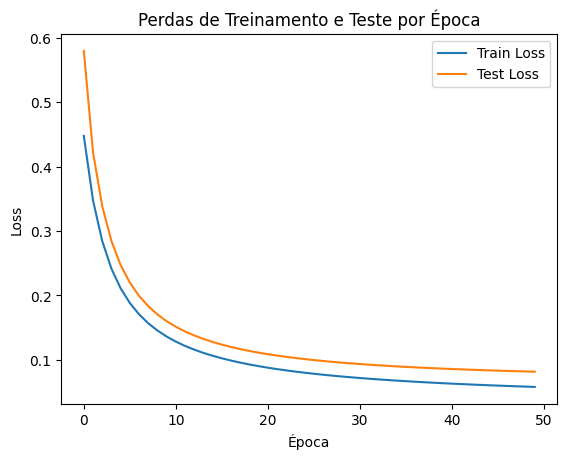

In [461]:
Gaussiano = Model(2, 2)
train_loop(Gaussiano, df_Gauss.X, df_Gauss.Y, 50, 0.03,ativacao='sigmoid', metodo_loss='binary_cross_entropy')

In [462]:
Gaussiano.evaluate(df_Gauss.X, df_Gauss.Y)

Erros: 5
Acertos: 395
Acurácia do mlp: 0.9875


<ipython-input-121-e26d519a37be>:30: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-119-d9b8891bbb60>:9: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



<ipython-input-121-e26d519a37be>:30: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-119-d9b8891bbb60>:9: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Média do loss para a época 0: 0.5114935261011123
Média do loss para a época 1: 0.5084328520298004
Média do loss para a época 2: 0.502498085051775
Média do loss para a época 3: 0.49276198700070384
Média do loss para a época 4: 0.4830150904133916
Média do loss para a época 5: 0.47643337983638046
Média do loss para a época 6: 0.47210389737039804
Média do loss para a época 7: 0.4687129885703325
Média do loss para a época 8: 0.465539785604924
Média do loss para a época 9: 0.46221430925652385
Média do loss para a época 10: 0.4585429702606052
Média do loss para a época 11: 0.45444521503522994
Média do loss para a época 12: 0.44993067081086335
Média do loss para a época 13: 0.4450762968696654
Média do loss para a época 14: 0.4399946408905089
Média do loss para a época 15: 0.4348043888760731
Média do loss para a época 16: 0.42961285654921083
Média do loss para a época 17: 0.42450852593872695
Média do loss para a época 18: 0.4195587749686092
Média do loss para a época 19: 0.4148104690620676
Médi

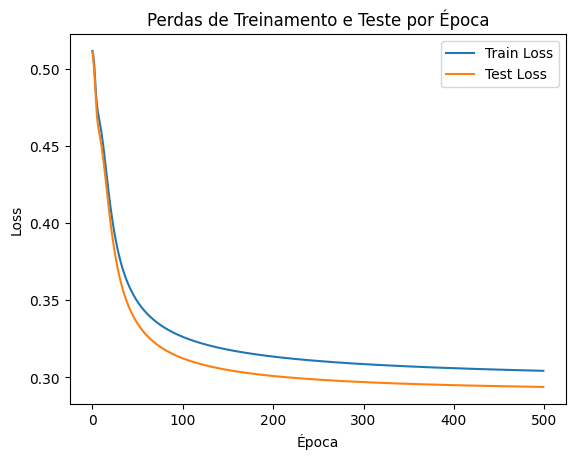

In [491]:
XOR = Model(2,2, [2, 1])   #aqui escolhemos propositalmente a primeira camada com 2 neuronios, e a ultima com 1. Isso pois, caso a primeira camada represente os problemas or e nand e a ultima o and, temos o xor
train_loop(XOR, df_XOR.X, df_XOR.Y, 500, 0.12, ativacao='sigmoid', metodo_loss='abs',batch_size=1)

In [492]:
XOR.evaluate(df_XOR.X, df_XOR.Y)

Erros: 117
Acertos: 283
Acurácia do mlp: 0.7075


<ipython-input-121-e26d519a37be>:30: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-119-d9b8891bbb60>:9: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



<ipython-input-121-e26d519a37be>:30: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-119-d9b8891bbb60>:9: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Média do loss para a época 0: 0.5372190347313881
Média do loss para a época 1: 0.5364562198519707
Média do loss para a época 2: 0.5357372245192528
Média do loss para a época 3: 0.5350511512160301
Média do loss para a época 4: 0.5343862280249596
Média do loss para a época 5: 0.5337290421128273
Média do loss para a época 6: 0.5330631950497627
Média do loss para a época 7: 0.5323673781752586
Média do loss para a época 8: 0.5316119214892387
Média do loss para a época 9: 0.5307528728246689
Média do loss para a época 10: 0.5297208952903748
Média do loss para a época 11: 0.5283994418382645
Média do loss para a época 12: 0.5265788996219635
Média do loss para a época 13: 0.523853769004345
Média do loss para a época 14: 0.519382306933403
Média do loss para a época 15: 0.5113599961996078
Média do loss para a época 16: 0.4965048509836197
Média do loss para a época 17: 0.4733858270943165
Média do loss para a época 18: 0.45077509596943854
Média do loss para a época 19: 0.4370422501862049
Média do lo

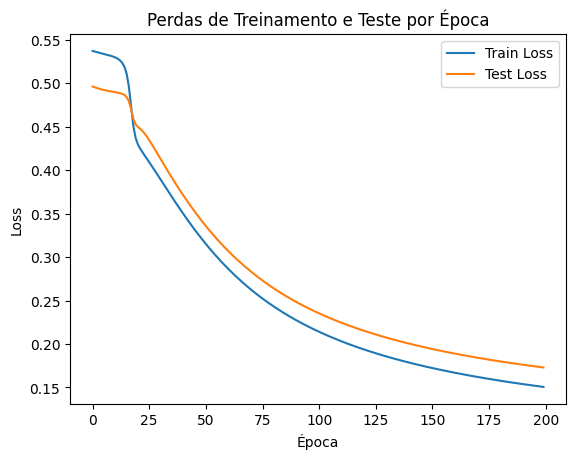

In [487]:
Circle = Model(2,2)
train_loop(Circle, torch.cat([df_Circle.X**2], dim=1), df_Circle.Y, 200, 0.03, ativacao='abs') #Aqui não estamos passando  a feature1 e feature2, mas estamos também ambas ao quadrado

In [493]:
Circle.evaluate(torch.cat([df_Circle.X**2], dim=1), df_Circle.Y), #usar relu

Erros: 35
Acertos: 365
Acurácia do mlp: 0.9125


<ipython-input-121-e26d519a37be>:30: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-119-d9b8891bbb60>:9: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



(None,)

<ipython-input-121-e26d519a37be>:30: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-119-d9b8891bbb60>:9: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Média do loss para a época 0: 0.49941036343574524
Média do loss para a época 1: 0.4970710071921349
Média do loss para a época 2: 0.49599156379699705
Média do loss para a época 3: 0.4954117089509964
Média do loss para a época 4: 0.4950580045580864
Média do loss para a época 5: 0.49482074558734895
Média do loss para a época 6: 0.4946495768427849
Média do loss para a época 7: 0.4945186945796013
Média do loss para a época 8: 0.49441371768713
Média do loss para a época 9: 0.4943260288238525
Média do loss para a época 10: 0.4942502099275589
Média do loss para a época 11: 0.49418266654014587
Média do loss para a época 12: 0.4941209146380425
Média do loss para a época 13: 0.4940632089972496
Média do loss para a época 14: 0.49400823682546613
Média do loss para a época 15: 0.49395501255989077
Média do loss para a época 16: 0.4939027577638626
Média do loss para a época 17: 0.4938508534431458
Média do loss para a época 18: 0.49379877030849456
Média do loss para a época 19: 0.4937460771203041
Média

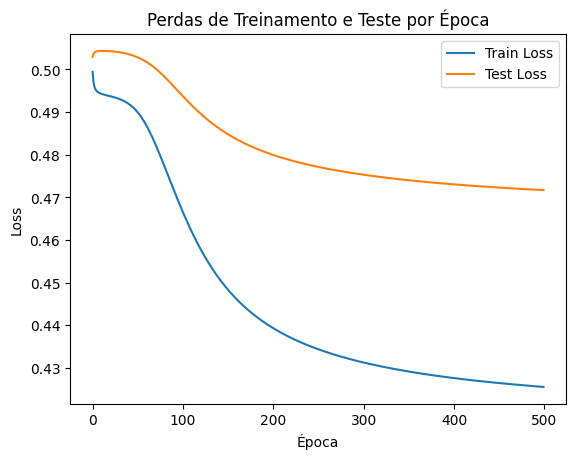

In [499]:
Spiral = Model(4,2, [2, 1])
train_loop(Spiral, torch.cat([df_Spiral.X **2, torch.sin(df_Spiral.X)], dim=1), df_Spiral.Y, 500, 0.2, ativacao='sigmoid', metodo_loss='abs')

In [500]:
Spiral.evaluate(torch.cat([df_Spiral.X **2, torch.sin(df_Spiral.X)], dim=1), df_Circle.Y)

Erros: 175
Acertos: 225
Acurácia do mlp: 0.5625


<ipython-input-121-e26d519a37be>:30: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-119-d9b8891bbb60>:9: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



# **k**-**N**earest **N**eighbors (**k-NN**)

Use a função [sklearn.neighbors.KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier) e encontre o número ótimo de vizinhos para cada um dos datasets acima.

In [ ]:
# TODO
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

x_train, y_train, x_test, y_test = train_test_split(df_Spiral.X, df_Spiral.Y)

spiral_accuracies = {}

for i in range(1,50):
  if i%2 !=0:
    spiral_accuracies[i] = 0

for j in range(0,1000):
  for i in range(1, 50):
    if i%2 != 0: #pegando valores ímpares de K para não haver empate.
      knn_classifier = KNeighborsClassifier(n_neighbors=i)
      knn_classifier.fit(x_train, y_train)
      y_pred = knn_classifier.predict(x_test)
      accuracy = accuracy_score(y_test, y_pred)
      spiral_accuracies[i] += accuracy


for chave, valor in spiral_accuracies.items():
  spiral_accuracies[chave] = valor / 1000

max_key = max(spiral_accuracies, key=spiral_accuracies.get)
print(f"O melhor valor de k é {max_key} com uma acurácia de {spiral_accuracies[max_key]}")
plt.title("Spiral dataset")
plt.xlabel("K value")
plt.ylabel("Accuracy")
plt.plot(spiral_accuracies.keys(), spiral_accuracies.values())
plt.show()


In [ ]:
x_train, y_train, x_test, y_test = train_test_split(df_Gauss.X, df_Gauss.Y)

gauss_accuracies = {}

for i in range(1,50):
  if i%2 !=0:
    gauss_accuracies[i] = 0

for j in range(0,1000):
  for i in range(1, 50):
    if i%2 != 0: #pegando valores ímpares de K para não haver empate.
      knn_classifier = KNeighborsClassifier(n_neighbors=i)
      knn_classifier.fit(x_train, y_train)
      y_pred = knn_classifier.predict(x_test)
      accuracy = accuracy_score(y_test, y_pred)
      gauss_accuracies[i] += accuracy

for chave, valor in gauss_accuracies.items():
  gauss_accuracies[chave] = valor / 1000

max_key = max(gauss_accuracies, key=gauss_accuracies.get)
print(f"O melhor valor de k é {max_key} com uma acurácia de {gauss_accuracies[max_key]}")
plt.title("Gaussian dataset")
plt.xlabel("K value")
plt.ylabel("Accuracy")
plt.plot(gauss_accuracies.keys(), gauss_accuracies.values())
plt.show()

In [ ]:
x_train, y_train, x_test, y_test = train_test_split(df_Circle.X, df_Circle.Y)

circle_accuracies = {}

for i in range(1,50):
  if i%2 !=0:
    circle_accuracies[i] = 0


for j in range(0,1000):
  for i in range(1, 50):
    if i%2 != 0: #pegando valores ímpares de K para não haver empate.
      knn_classifier = KNeighborsClassifier(n_neighbors=i)
      knn_classifier.fit(x_train, y_train)
      y_pred = knn_classifier.predict(x_test)
      accuracy = accuracy_score(y_test, y_pred)
      circle_accuracies[i] += accuracy

for chave, valor in circle_accuracies.items():
  circle_accuracies[chave] = valor / 1000

max_key_circle = max(circle_accuracies, key=circle_accuracies.get)
print(f"O melhor valor de k é {max_key} com uma acurácia de {circle_accuracies[max_key]}")
plt.title("Circle dataset")
plt.xlabel("K value")
plt.ylabel("Accuracy")
plt.plot(circle_accuracies.keys(), circle_accuracies.values())
plt.show()

In [ ]:
x_train, y_train, x_test, y_test = train_test_split(df_XOR.X, df_XOR.Y)

XOR_accuracies = {}

for i in range(1,50):
  if i%2 !=0:
    XOR_accuracies[i] = 0

for j in range(0,1000):
  for i in range(1, 50):
    if i%2 != 0: #pegando valores ímpares de K para não haver empate.
      knn_classifier = KNeighborsClassifier(n_neighbors=i)
      knn_classifier.fit(x_train, y_train)
      y_pred = knn_classifier.predict(x_test)
      accuracy = accuracy_score(y_test, y_pred)
      XOR_accuracies[i] += accuracy

for chave, valor in XOR_accuracies.items():
  XOR_accuracies[chave] = valor / 1000

max_key = max(XOR_accuracies, key=XOR_accuracies.get)
print(f"O melhor valor de k é {max_key} com uma acurácia de {XOR_accuracies[max_key]}")
plt.title("XOR dataset")
plt.xlabel("K value")
plt.ylabel("Accuracy")
plt.plot(XOR_accuracies.keys(), XOR_accuracies.values())
plt.show()

Compare as melhores performances obtidas com as MLPs e as melhores obtidas com o k-NN. Quais as vantagens e desvantagens de cada algoritmo para os datasets explorados? Se tivesse que escolher um dos dois algoritmos, qual seu time escolheria?

**Resposta:** TODO

In [ ]:
# TODO

# Dica para um dos exercícios:

In [ ]:
torch.randperm(4)
torch.rand(3)